<a href="https://colab.research.google.com/github/sebabecerra/Red-Semantica/blob/main/Analisis_Memoria_GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Entorno y gestion de paquetes
!pip install spacy --quiet
#!pip spacy download es_core_news_sm --quiet
!python -m spacy download es_core_news_md --quiet
!python -m spacy download es_core_news_sm --quiet

!sudo apt install build-essential libpoppler-cpp-dev pkg-config python3-dev
!pip install pdftotext
!pip install PyPDF2
!pip install pdfminer.six
!sudo apt install build-essential libpoppler-cpp-dev pkg-config python3-dev
!pip install pdftotext
!pip install PyPDF2
!pip install pdfminer.six
!pip install openai==0.28

In [ ]:
# Configuración inicial
import warnings
warnings.filterwarnings('ignore')

# Importación de librerías
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import string
import os
import re
from IPython.display import Image
from itertools import compress
from PyPDF2 import PdfReader
import pdftotext
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import openai
import unicodedata
from string import digits


In [ ]:
# Descargar recursos de NLTK (solo se ejecuta una vez)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Cargar stopwords en español
stopword_es = set(nltk.corpus.stopwords.words('spanish'))

# Cargar el modelo de spaCy en español
nlp = spacy.load("es_core_news_sm")

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Definir rutas y crear directorio
project_dir = '/content/drive/MyDrive/RedSemantica'
pdf_url = "https://cdn3.bci.cl/uploads/fdadf18f-b581-4548-bec2-e97750800f2e/original/Mem_Bci_2023_c.pdf"
pdf_filename = "Memoria_BCI_2023.pdf"
txt_filename = 'bci.txt'

# Crear el directorio de trabajo si no existe
os.makedirs(project_dir, exist_ok=True)

# Cambiar el directorio actual al directorio del proyecto
os.chdir(project_dir)

# Descargar el archivo PDF solo si no existe
if not os.path.exists(pdf_filename):
    os.system(f"wget -O {pdf_filename} {pdf_url}")

# Convertir el PDF a texto si no se ha hecho antes
if not os.path.exists(txt_filename):
    with open(pdf_filename, "rb") as f:
        pdf = pdftotext.PDF(f)
    with open(txt_filename, 'w') as f:
        f.write("\n\n".join(pdf))

# Leer y procesar el texto desde el archivo generado
with open(txt_filename, 'r') as f:
    texto = f.read()

Mounted at /content/drive


Primera 10 palabras del texto:
           token
0     integrada
1        acerca
2     integrada
3         surge
4       proceso
5  recopilacion
6      analisis
7         datos
8        abarca
9         todas
Frecuencia de palabras:
              token  counts
0      financieros     248
1      corporativo     223
2      informacion     213
3              esg     201
4         gobierno     189
5           riesgo     187
6      estrategico     167
7         informes     166
8         clientes     163
9        integrada     160
10           total     159
11       adicional     158
12         riesgos     156
13      directorio     151
14          comite     141
15         gestion     128
16         mercado     127
17       servicios     120
18  sostenibilidad     115
19     proveedores     112
20        personas     111
21        empresas     109
22        millones     105
23      estrategia      95
24         capital      90
25   colaboradores      88
26         activos      88
27         

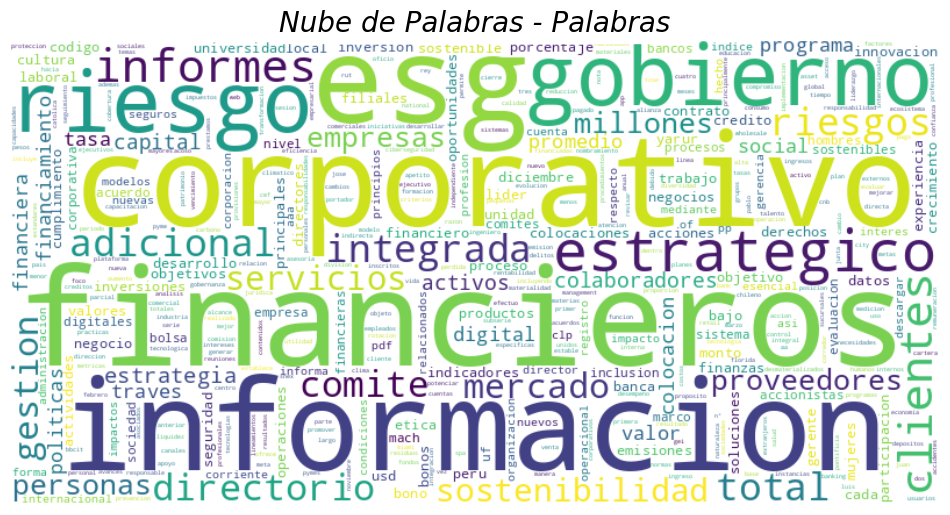

Frecuencia de bigramas NOUN-ADJ:
                       ngram  counts
0      gobierno corporativo     155
1      informes financieros     152
2     servicios financieros      47
3             mercado local      31
4              serie codigo      25
5   condiciones especificas      22
6       productos servicios      21
7        riesgo corporativo      20
8      universidad catolica      19
9          cambio climatico      17
10         hombres contrato      16
11           corredor bolsa      16
12          mujeres hombres      16
13      naturaleza juridica      15
14    participacion directa      15
15   proveedores nacionales      14
16         temas materiales      14
17       mercado financiero      14
18        canales digitales      14
19   responsabilidad social      13
20      estrategia metricas      13
21         mujeres contrato      13
22           respecto total      12
23  proveedores extranjeros      12
24           grupos interes      12
25       riesgo operacional   

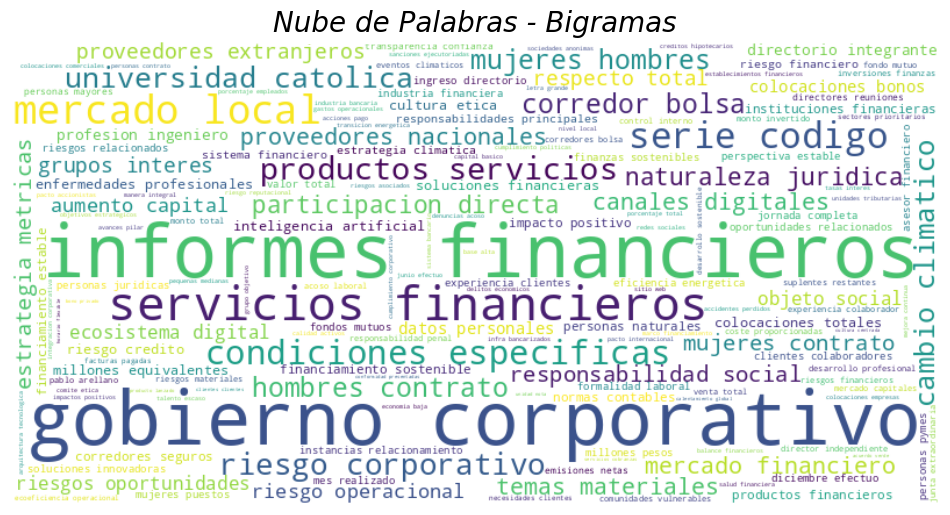

In [ ]:
# Ampliar la lista de stopwords con términos específicos
custom_stopwords = {
    "artículo", "capítulo", "decreto", "n°", '°', "inciso", "dicha", "año",
    "fija", "constitucion", "politica", "republica", "ministerio", "secretaría",
    "general", "presidencia", "publicación", "promulgación", "tipo", "versión",
    "última", "ultima", "modificación", "biblioteca", "congreso", "nacional",
    "página", "documento", "www.leychile.cl", "generado", "agosto", "bcnclitu",
    "septiembre", "refiere", "ley", "orgánica", "plazo", "siguientes", "miembros",
    "siguiente", 'inciso', 'número', 'efecto', 'fecha', 'años', 'procederá',
    'mayo', 'dichas', 'formas', "incisos", 'deberán', 'deber', 'º', 'nº', 'ámbito',
    'ámbitos', 'áreas', 'velar', 'ad', 'única', 'únicas', 'único', 'útiles',
    'constitución', 'constitucional', 'deberá', 'determinará', 'chile', 'ser',
    'por', 'ningún', 'caso', 'según', 'corresponda', 'treinta', 'días',
    'funcionarios', 'funcionarias', 'diputados', 'diputadas', 'ministros',
    'ministras', 'consejeros', 'consejeras', 'autónomo', 'autónomos', 'organismo',
    'organismos', 'trabajadores', 'trabajadoras', 'jueces', 'juezas', "medidas",
    "necesarias", "podrá", "establecer", "demás", "atribuciones", "disposición",
    "transitoria", "medidas", "necesarias", "texto", "refundido",
    "disposiciones", "transitorias", "vigentes", "ratificados", "política",
    "república", 'preámbulo', 'mayoria', 'presidente', 'presidentes', "presidenta",
    'presidentas', "adolecentes", "niños", "niñas", 'servicio', 'electoral',
    "memoria", "bci", "reportes", "banco", "reporte",
}
stopword_es.update(custom_stopwords)

# Cargar el modelo de spaCy en español
nlp = spacy.load("es_core_news_sm")

def limpiar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()

    # Tokenización y eliminación de stopwords
    text_tokens = word_tokenize(texto)
    tokens_without_sw = [word for word in text_tokens if word not in stopword_es]

    # Reunir tokens en texto, separando solo por un espacio
    texto = " ".join(tokens_without_sw)

    # Eliminación de puntuación, dígitos y tildes
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    texto = texto.translate(str.maketrans('', '', string.digits))
    texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')

    # Eliminar instancias específicas
    texto = texto.replace('º', '').replace('ª', '').replace('mm', '')
    texto = re.sub(r'\bnd\b', '', texto)

    # Filtrar nuevamente para eliminar palabras de longitud 1 después de limpiar
    text_tokens = word_tokenize(texto)
    texto = " ".join([word for word in text_tokens if len(word) > 1])

    # Limpieza adicional de espacios y saltos de línea
    texto = re.sub(r'\s+', ' ', texto).strip()

    return texto


# Analizar texto y generar DataFrame de tokens
def analizar_texto(texto_filtrado):
    tokens_texto = word_tokenize(texto_filtrado)
    df_tokens_clean_texto = pd.DataFrame(tokens_texto, columns=['token'])

    # Frecuencia de palabras
    tokens_count_texto = df_tokens_clean_texto['token'].value_counts().rename_axis('token').reset_index(name='counts')
    tokens_count_texto = tokens_count_texto[tokens_count_texto['counts'] > 3]

    return df_tokens_clean_texto, tokens_count_texto

# Generar nube de palabras
def generar_wordcloud(tokens_count, title):
    # Use 'ngram' as the key for bigram DataFrames
    key = 'ngram' if 'ngram' in tokens_count.columns else 'token'
    data = dict(zip(tokens_count[key].tolist(), tokens_count['counts'].tolist()))
    wc = WordCloud(background_color='white', width=800, height=400, max_words=500).generate_from_frequencies(data)

    plt.figure(figsize=(12, 12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20, loc="center", backgroundcolor='white', color='black', fontstyle='italic')
    plt.show()

# Procesamiento de bigramas (NOUN-ADJ)
def bigramas_noun_adj(df_tokens_clean_texto, nlp):
    tokens_texto = df_tokens_clean_texto['token'].tolist()
    mytext = nlp(" ".join(tokens_texto))

    tokens_texto = [token.text for token in mytext]
    tags_texto = [token.tag_ for token in mytext]

    bi_tokens_texto = [' '.join(x) for x in list(nltk.bigrams(tokens_texto))]
    bi_tag_texto = [' '.join(x) for x in list(nltk.bigrams(tags_texto))]

    # Filtrar bigramas NOUN-ADJ
    data_tag_texto = pd.DataFrame({'token_bi': bi_tokens_texto, 'tag_bi': bi_tag_texto})
    data_tag_texto = data_tag_texto[data_tag_texto["tag_bi"] == "NOUN ADJ"]

    return data_tag_texto

# Ejecución principal
def main(texto):
    texto_filtrado = limpiar_texto(texto)

    df_tokens_clean_texto, tokens_count_texto = analizar_texto(texto_filtrado)

    print("Primera 10 palabras del texto:\n", df_tokens_clean_texto.head(10))
    print("Frecuencia de palabras:\n", tokens_count_texto.head(30))

    # Guardar resultados en CSV
    tokens_count_texto.to_csv('/content/tokens_count_texto.csv', encoding='utf-8', index=False)

    # Generar nube de palabras
    generar_wordcloud(tokens_count_texto, "Nube de Palabras - Palabras")

    # Análisis de bigramas NOUN-ADJ
    data_tag_texto = bigramas_noun_adj(df_tokens_clean_texto, nlp)
    ngram_noun_adj_count_texto = data_tag_texto['token_bi'].value_counts().rename_axis('ngram').reset_index(name='counts')

    print("Frecuencia de bigramas NOUN-ADJ:\n", ngram_noun_adj_count_texto.head(30))

    # Guardar bigramas en CSV
    ngram_noun_adj_count_texto.to_csv('/content/ngram_noun_adj_count_texto.csv', encoding='utf-8', index=False)

    # Generar nube de palabras para bigramas
    generar_wordcloud(ngram_noun_adj_count_texto, "Nube de Palabras - Bigramas")

# Suponiendo que 'texto' ya está disponible, ejecutamos la función principal
main(texto)


In [ ]:
texto_filtrado = limpiar_texto(texto)
texto_filtrado

'integrada acerca integrada surge proceso recopilacion analisis datos abarca todas impactos sociales ambientales economicos objetivo describir como crea valor grupos interes como gestionado factores financieros financieros inciden resultados perspectivas contenido informe elaborado siguiendo directrices practica comentarios gerencia normas internacionales informacion financiera niif norma caracter comision mercado financiero cmf aplicable bancos partir memorias anuales definir temas significativos punto vista sostenibilidad –desarrollados memoria– aplico nueva metodologia doble materialidad concepto reconoce importancia considerar impactos empresa genera riesgos oportunidades sostenibilidad afectan resultados perspectivas notas importantes diferencias normas contables unidos informacion financiera filiales unidos prepara originalmente acuerdo normas contables ee uu us gaap cuales difieren normas contables instrucciones cmf principales diferencias normas us gaap normas contables cmf rel

In [ ]:
from collections import Counter
from nltk.util import ngrams
from textblob import TextBlob
import numpy as np

def analizar_esg(texto_filtrado):
    # Análisis de frecuencia de "esg"
    doc = nlp(texto_filtrado)
    palabras = [token.text for token in doc]
    frecuencia_palabras = Counter(palabras)
    frecuencia_esg = {palabra: frecuencia for palabra, frecuencia in frecuencia_palabras.items() if "esg" in palabra}

    print("Frecuencia de 'esg' y derivados:\n", frecuencia_esg)

    # Análisis de co-ocurrencias con "esg"
    oraciones = list(doc.sents)
    co_ocurrencias = []

    for oracion in oraciones:
        if any("esg" in token.lemma_ for token in oracion):
            palabras_coocurrencias = [token.text for token in oracion if token.text != "esg"]
            co_ocurrencias.extend(palabras_coocurrencias)

    co_ocurrencias_frecuencia = Counter(co_ocurrencias)
    print("\nPalabras más comunes que co-ocurren con 'esg':\n", co_ocurrencias_frecuencia.most_common(10))

    # Análisis de sentimientos en contextos de "esg"
    sentimientos = []
    for oracion in oraciones:
        if any("esg" in token.lemma_ for token in oracion):
            blob = TextBlob(oracion.text)
            sentimientos.append(blob.sentiment.polarity)

    promedio_sentimiento = np.mean(sentimientos) if sentimientos else 0
    print("\nPromedio de Sentimiento en Contextos de 'esg':", promedio_sentimiento)

    # Extracción de bigramas/trigramas que incluyan "esg"
    bigramas = list(ngrams(palabras, 2))
    trigramas = list(ngrams(palabras, 3))

    bigramas_esg = [" ".join(bigrama) for bigrama in bigramas if "esg" in bigrama]
    trigramas_esg = [" ".join(trigrama) for trigrama in trigramas if "esg" in trigrama]

    print("\nBigramas con 'esg':\n", bigramas_esg)
    print("\nTrigramas con 'esg':\n", trigramas_esg)

    # Generación de resumen de oraciones clave con "esg"
    oraciones_clave = [oracion.text for oracion in oraciones if any("esg" in token.lemma_ for token in oracion)]
    resumen = " ".join(oraciones_clave[:5])  # Resumimos con las primeras 5 oraciones clave

    print("\nResumen de Oraciones Clave sobre 'esg':\n", resumen)

    # Devolver los valores necesarios para la siguiente parte del análisis
    return resumen, co_ocurrencias_frecuencia, promedio_sentimiento



In [ ]:
from collections import Counter
from nltk.util import ngrams
from textblob import TextBlob
import numpy as np

def analizar_termino(texto_filtrado, termino):
    # Verificar si termino es una lista o una cadena y normalizar a lista
    if isinstance(termino, str):
        terminos = [termino.lower()]
    else:
        terminos = [t.lower() for t in termino]

    # Análisis de frecuencia del término
    doc = nlp(texto_filtrado)
    palabras = [token.text.lower() for token in doc]
    total_palabras = len(palabras)
    frecuencia_palabras = Counter(palabras)
    frecuencia_termino = {palabra: frecuencia for palabra, frecuencia in frecuencia_palabras.items() if any(t in palabra for t in terminos)}

    print(f"Frecuencia de {terminos} y derivados:\n", frecuencia_termino)

    # Frecuencia relativa del término
    frecuencia_relativa = {t: frecuencia_termino.get(t, 0) / total_palabras for t in terminos}
    print(f"Frecuencia relativa de {terminos}:\n", frecuencia_relativa)

    # Análisis de co-ocurrencias con el término
    oraciones = list(doc.sents)
    co_ocurrencias = []
    longitudes_oraciones = []

    for oracion in oraciones:
        if any(t in token.lemma_.lower() for t in terminos for token in oracion):
            palabras_coocurrencias = [token.text for token in oracion if not any(t in token.text.lower() for t in terminos)]
            co_ocurrencias.extend(palabras_coocurrencias)
            longitudes_oraciones.append(len(oracion))

    co_ocurrencias_frecuencia = Counter(co_ocurrencias)
    print(f"\nPalabras más comunes que co-ocurren con {terminos}:\n", co_ocurrencias_frecuencia.most_common(10))

    # Diversidad de contexto
    diversidad_contexto = len(co_ocurrencias_frecuencia)
    print(f"Diversidad de contexto de {terminos} (número de palabras diferentes que co-ocurren): {diversidad_contexto}")

    # Análisis de sentimientos en contextos del término
    sentimientos = []
    for oracion in oraciones:
        if any(t in token.lemma_.lower() for t in terminos for token in oracion):
            blob = TextBlob(oracion.text)
            sentimientos.append(blob.sentiment.polarity)

    promedio_sentimiento = np.mean(sentimientos) if sentimientos else 0
    varianza_sentimiento = np.var(sentimientos) if sentimientos else 0
    print(f"\nPromedio de Sentimiento en Contextos de {terminos}: {promedio_sentimiento}")
    print(f"Varianza de Sentimiento en Contextos de {terminos}: {varianza_sentimiento}")

    # Longitud media de las oraciones que contienen el término
    longitud_media_oracion = np.mean(longitudes_oraciones) if longitudes_oraciones else 0
    print(f"Longitud media de las oraciones que contienen {terminos}: {longitud_media_oracion} palabras")

    # Extracción de bigramas/trigramas que incluyan el término
    bigramas = list(ngrams(palabras, 2))
    trigramas = list(ngrams(palabras, 3))

    bigramas_termino = [" ".join(bigrama) for bigrama in bigramas if any(t in bigrama for t in terminos)]
    trigramas_termino = [" ".join(trigrama) for trigrama in trigramas if any(t in trigrama for t in terminos)]

    print(f"\nBigramas con {terminos}:\n", bigramas_termino[:10])
    print(f"\nTrigramas con {terminos}:\n", trigramas_termino[:10])

    # Generación de resumen de oraciones clave con el término
    oraciones_clave = [oracion.text for oracion in oraciones if any(t in token.lemma_.lower() for t in terminos for token in oracion)]
    resumen = " ".join(oraciones_clave[:5])  # Resumimos con las primeras 5 oraciones clave

    print(f"\nResumen de Oraciones Clave sobre {terminos}:\n", resumen)

    # Devolver los valores necesarios para la siguiente parte del análisis
    return {
        "resumen": resumen,
        "frecuencia_termino": frecuencia_termino,
        "frecuencia_relativa": frecuencia_relativa,
        "co_ocurrencias_frecuencia": co_ocurrencias_frecuencia,
        "diversidad_contexto": diversidad_contexto,
        "promedio_sentimiento": promedio_sentimiento,
        "varianza_sentimiento": varianza_sentimiento,
        "longitud_media_oracion": longitud_media_oracion,
        "bigramas_termino": bigramas_termino,
        "trigramas_termino": trigramas_termino,
    }


In [ ]:
from collections import Counter
from nltk.util import ngrams
from textblob import TextBlob
import numpy as np

def limitar_palabras(texto, max_palabras=100):
    palabras = texto.split()
    if len(palabras) > max_palabras:
        return " ".join(palabras[:max_palabras]) + "..."
    else:
        return texto

def analizar_termino(texto_filtrado, termino):
    # Verificar si termino es una lista o una cadena y normalizar a lista
    if isinstance(termino, str):
        terminos = [termino.lower()]
    else:
        terminos = [t.lower() for t in termino]

    # Unir los términos compuestos en una sola cadena si hay más de una palabra
    terminos = [" ".join(t.split()) for t in terminos]

    # Análisis de frecuencia del término
    doc = nlp(texto_filtrado)
    palabras = [token.text.lower() for token in doc]
    total_palabras = len(palabras)

    # Frecuencia de términos compuestos
    texto_completo = " ".join(palabras)
    frecuencia_termino = {t: texto_completo.count(t) for t in terminos}

    print(f"Frecuencia de {terminos} y derivados:\n", frecuencia_termino)

    # Frecuencia relativa del término
    frecuencia_relativa = {t: frecuencia_termino.get(t, 0) / total_palabras for t in terminos}
    print(f"Frecuencia relativa de {terminos}:\n", frecuencia_relativa)

    # Análisis de co-ocurrencias con el término
    oraciones = list(doc.sents)
    co_ocurrencias = []
    longitudes_oraciones = []

    for oracion in oraciones:
        if any(t in oracion.text.lower() for t in terminos):
            palabras_coocurrencias = [token.text for token in oracion if not any(t in token.text.lower() for t in terminos)]
            co_ocurrencias.extend(palabras_coocurrencias)
            longitudes_oraciones.append(len(oracion))

    co_ocurrencias_frecuencia = Counter(co_ocurrencias)
    print(f"\nPalabras más comunes que co-ocurren con {terminos}:\n", co_ocurrencias_frecuencia.most_common(10))

    # Diversidad de contexto
    diversidad_contexto = len(co_ocurrencias_frecuencia)
    print(f"Diversidad de contexto de {terminos} (número de palabras diferentes que co-ocurren): {diversidad_contexto}")

    # Análisis de sentimientos en contextos del término
    sentimientos = []
    for oracion in oraciones:
        if any(t in oracion.text.lower() for t in terminos):
            blob = TextBlob(oracion.text)
            sentimientos.append(blob.sentiment.polarity)

    promedio_sentimiento = np.mean(sentimientos) if sentimientos else 0
    varianza_sentimiento = np.var(sentimientos) if sentimientos else 0
    print(f"\nPromedio de Sentimiento en Contextos de {terminos}: {promedio_sentimiento}")
    print(f"Varianza de Sentimiento en Contextos de {terminos}: {varianza_sentimiento}")

    # Longitud media de las oraciones que contienen el término
    longitud_media_oracion = np.mean(longitudes_oraciones) if longitudes_oraciones else 0
    print(f"Longitud media de las oraciones que contienen {terminos}: {longitud_media_oracion} palabras")

    # Extracción de bigramas/trigramas que incluyan el término
    bigramas = list(ngrams(palabras, 2))
    trigramas = list(ngrams(palabras, 3))

    bigramas_termino = [" ".join(bigrama) for bigrama in bigramas if any(t in " ".join(bigrama) for t in terminos)]
    trigramas_termino = [" ".join(trigrama) for trigrama in trigramas if any(t in " ".join(trigrama) for t in terminos)]

    print(f"\nBigramas con {terminos}:\n", bigramas_termino[:10])
    print(f"\nTrigramas con {terminos}:\n", trigramas_termino[:10])

    # Generación de resumen de oraciones clave con el término
    oraciones_clave = [oracion.text for oracion in oraciones if any(t in oracion.text.lower() for t in terminos)]
    resumen = " ".join(oraciones_clave[:5])  # Resumimos con las primeras 5 oraciones clave
    resumen_limitado = limitar_palabras(resumen, 300)

    print(f"\nResumen de Oraciones Clave sobre {terminos} (Limitado a 100 palabras):\n", resumen_limitado)

    # Devolver los valores necesarios para la siguiente parte del análisis
    return {
        "resumen": resumen_limitado,
        "frecuencia_termino": frecuencia_termino,
        "frecuencia_relativa": frecuencia_relativa,
        "co_ocurrencias_frecuencia": co_ocurrencias_frecuencia,
        "diversidad_contexto": diversidad_contexto,
        "promedio_sentimiento": promedio_sentimiento,
        "varianza_sentimiento": varianza_sentimiento,
        "longitud_media_oracion": longitud_media_oracion,
        "bigramas_termino": bigramas_termino,
        "trigramas_termino": trigramas_termino,
    }


In [ ]:
# Suponiendo que 'texto_filtrado' ya está disponible
resultados = analizar_termino(texto_filtrado, "inteligencia artificial")

# Ahora 'resultados' contiene todas las métricas interesantes# Paso 2: Preparar los datos para el LLM
resumen_oraciones_clave = resultados["resumen"]
co_ocurrencias = ", ".join([f"{palabra}: {frecuencia}" for palabra, frecuencia in resultados["co_ocurrencias_frecuencia"].most_common(10)])
sentimientos = f"{resultados['promedio_sentimiento']:.10f}"

Frecuencia de ['inteligencia artificial'] y derivados:
 {'inteligencia artificial': 8}
Frecuencia relativa de ['inteligencia artificial']:
 {'inteligencia artificial': 0.00027168376010323984}

Palabras más comunes que co-ocurren con ['inteligencia artificial']:
 [('financieros', 157), ('informacion', 134), ('corporativo', 134), ('esg', 132), ('riesgo', 127), ('clientes', 122), ('gobierno', 116), ('riesgos', 115), ('estrategico', 108), ('total', 102)]
Diversidad de contexto de ['inteligencia artificial'] (número de palabras diferentes que co-ocurren): 4091

Promedio de Sentimiento en Contextos de ['inteligencia artificial']: 0.001872896204895458
Varianza de Sentimiento en Contextos de ['inteligencia artificial']: 0.0006634617968573268
Longitud media de las oraciones que contienen ['inteligencia artificial']: 4423.25 palabras

Bigramas con ['inteligencia artificial']:
 ['inteligencia artificial', 'inteligencia artificial', 'inteligencia artificial', 'inteligencia artificial', 'inteligenc

In [ ]:
#No correr
import openai

# Configura tu clave API de OpenAI
#openai.api_key = ""

# Función para generar un resumen utilizando un LLM con la nueva API
def generar_resumen_llm(termino, oraciones_clave, co_ocurrencias, sentimientos):
    prompt = f"""
    Estoy analizando un texto para entender cómo se discute el término '{termino}'.
    A continuación te doy un resumen de las oraciones clave donde aparece la palabra "{termino}" o sus derivados:

    {oraciones_clave}

    Además, he identificado las siguientes palabras que suelen aparecer junto a "{termino}":

    {co_ocurrencias}

    El sentimiento general en estos contextos es {sentimientos}.

    Con base en esta información, ¿podrías generar un resumen detallado que
    describa cómo se trata el término '{termino}' en este texto?
    Por favor, incluye cualquier observación importante sobre el tono y las ideas
    principales relacionadas con '{termino}'.
    """

    response = openai.ChatCompletion.create(
      model="gpt-4",  # Usa el modelo que prefieras
      messages=[
        {"role": "system", "content": "Eres un asistente que ayuda a analizar textos complejos."},
        {"role": "user", "content": prompt},
      ],
      max_tokens=500,  # Ajusta según lo que necesites
      temperature=0.7,
      top_p=1,
      n=1,
    )

    resumen_generado = response['choices'][0]['message']['content'].strip()
    return resumen_generado



In [ ]:
# Genera el resumen utilizando el LLM
resumen_inteligencia_artificial = generar_resumen_llm("inteligencia artificial", resumen_oraciones_clave, co_ocurrencias, sentimientos)
# Imprimir el resumen generado
print(resumen_inteligencia_artificial)

En el texto, la 'inteligencia artificial' (IA) se presenta como una fuerza disruptiva y generativa que tiene el potencial de transformar los modelos de negocio, la productividad y la eficiencia de las organizaciones. Se enfatiza particularmente su impacto en la industria de servicios financieros. Se menciona el surgimiento de la IA generativa, que es capaz de crear contenido nuevo a partir de datos existentes, destacando la rápida expansión de esta tecnología y el lanzamiento de aplicaciones como chatgpt.

La IA se vincula con la posibilidad de ofrecer a los clientes experiencias personalizadas, aumentar la eficiencia mediante la automatización de procesos y el empoderamiento de los colaboradores. También se hace hincapié en la generación de activos analíticos y modelos predictivos a través de IA. Sin embargo, también se reconoce el desafío que representa la IA generativa para mejorar la experiencia del cliente y la eficiencia.

Las palabras que a menudo acompañan a 'inteligencia artif